# BERTtopic

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
import pickle

In [2]:
data = pd.read_csv("../../data/processed/clean_reviews.csv", parse_dates=['Time'])
data.columns = [x.lower().replace(" ", "_") for x in data.columns ]
data.head()

sentiment       time                                               text  \
0  positive 2021-06-18  This is a very healthy dog food. Good for thei...   
1  positive 2021-07-07  I've been very pleased with the Natural Balanc...   
2  positive 2021-06-18  Before I was educated about feline nutrition, ...   
3  positive 2021-07-07  My holistic vet recommended this, along with a...   
4  positive 2021-01-07  I bought this coffee because its much cheaper ...   

                                        cleaned_text  label  
0  healthy dog food good digestion also good smal...      1  
1  pleased natural balance dog food dog issue dog...      1  
2  educate feline nutrition allow cat become addi...      1  
3  holistic vet recommend along brand try cat pre...      1  
4  buy coffee much cheap ganocafe organic reishi ...      1

## Prepare model

### Prepare embeddings

In [3]:
# # Prepare embeddings
# sentence_model = SentenceTransformer("all-MiniLM-L12-v2")
# embeddings = sentence_model.encode(data['cleaned_text'], show_progress_bar=True)

In [4]:
# # save embeddings
# with open('BERTopic_embeddings.pickle', 'wb') as pkl:
#     pickle.dump(embeddings, pkl)

In [5]:
# Load embeddings
with open('BERTopic_embeddings.pickle', 'rb') as pkl:
    embeddings = pickle.load(pkl)

### UMAP for dimensionality reduction

In [6]:
umap_model = UMAP(n_neighbors=100, 
                  n_components=3, 
                  min_dist=0.0, 
                  metric='cosine', 
                  random_state=4263)

### HDBSCAN for clustering

In [7]:
hdbscan_model = HDBSCAN(min_cluster_size=50,
                        min_samples=20,
                        metric='euclidean',
                        prediction_data = True)

### Initialize BERTopic

In [8]:
# Initiate BERTopic
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       umap_model=umap_model,
                       language="english",
                       calculate_probabilities=True,
                       nr_topics="auto")
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(data['cleaned_text'], embeddings)

## Evaluate model

In [9]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                                   Name
0      -1   2010               -1_taste_good_like_great
1       0    511              0_coffee_cup_taste_flavor
2       1    422              1_sauce_soup_noodle_pasta
3       2    397              2_price_order_product_buy
4       3    341                3_tea_green_taste_drink
5       4    227                 4_dog_food_treat_china
6       5    220                 5_cake_gluten_mix_free
7       6    160                 6_baby_snack_food_love
8       7    130            7_bar_snack_granola_protein
9       8    129            8_chocolate_hot_cocoa_taste
10      9    123                 9_salt_jerky_pork_rind
11     10    111              10_chip_kettle_bag_potato
12     11     98             11_juice_orange_soda_drink
13     12     88            12_water_drink_energy_taste
14     13     84            13_peanut_butter_almond_nut
15     14     80  14_candy_licorice_pomegranate_picture
16     15     72                15_cat_food_eat_felidae
17     16     70          16_sugar_stevia_sweetener_use
18     17     66            17_cereal_fiber_eat_healthy
19     18     54              18_popcorn_pop_oil_popper
20     19     51              19_oil_olive_coconut_hair

In [10]:
# Get top 10 terms for a topic
topic_model.get_topic(2)

[('price', 0.04004471782148473),
 ('order', 0.03805942079702068),
 ('product', 0.03436297157198052),
 ('buy', 0.034178849697882534),
 ('ship', 0.028779242526950664),
 ('store', 0.02646071178550077),
 ('box', 0.026356710630116357),
 ('good', 0.02552144863395328),
 ('item', 0.0252925778658006),
 ('amazon', 0.023700436458119433)]

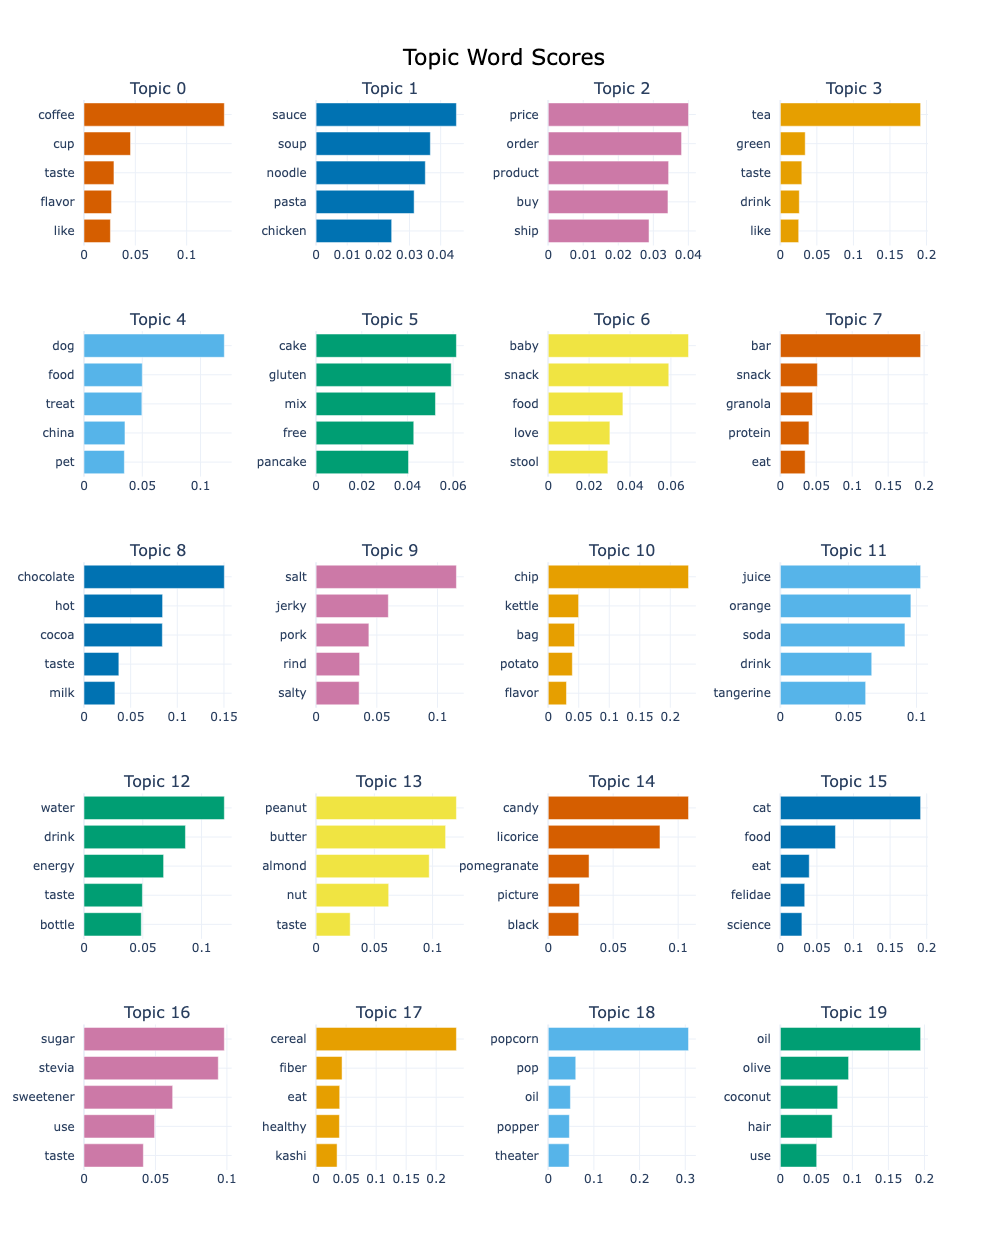

In [11]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=20)

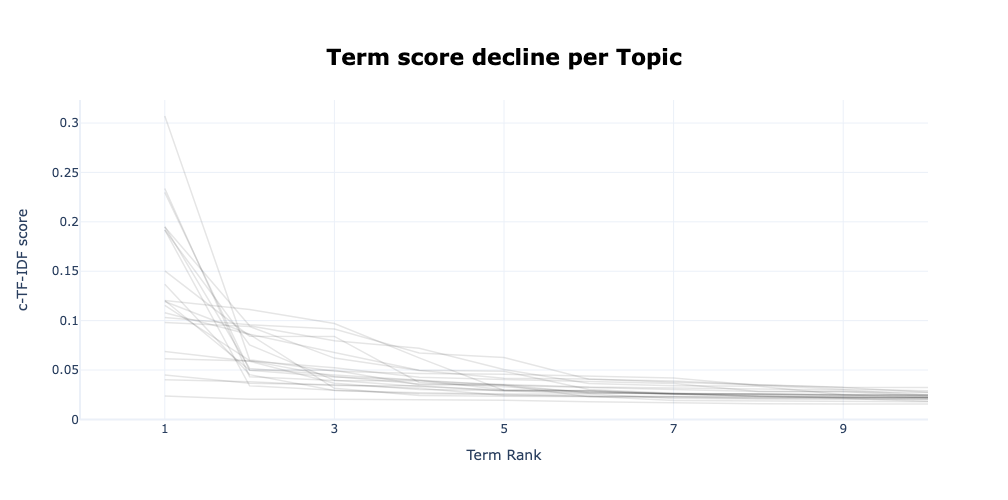

In [12]:
# Visualize term rank decrease
topic_model.visualize_term_rank()

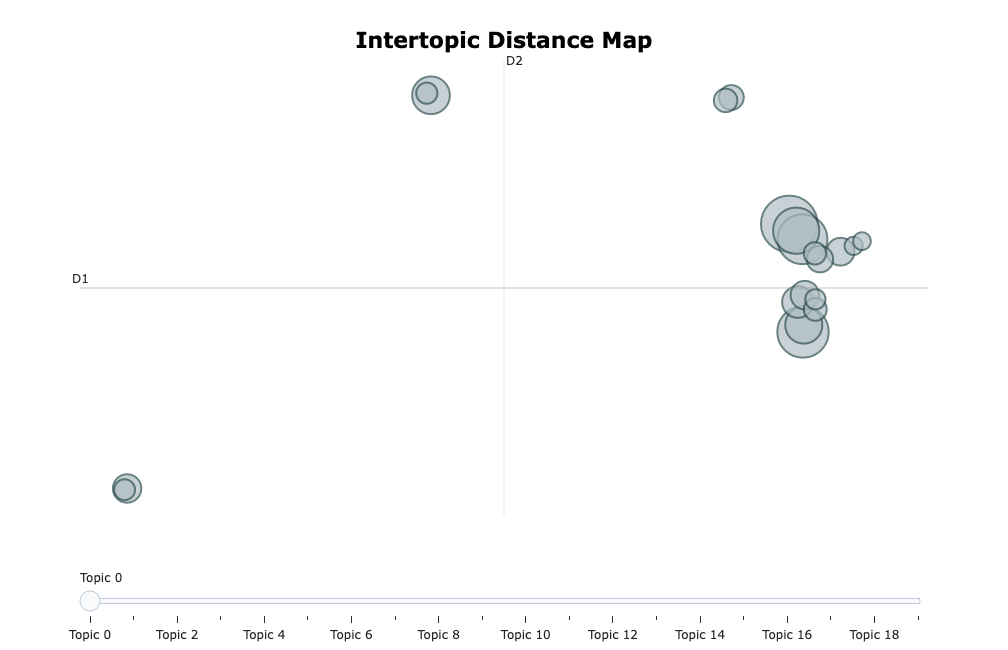

In [13]:
# Visualize intertopic distance
topic_model.visualize_topics()

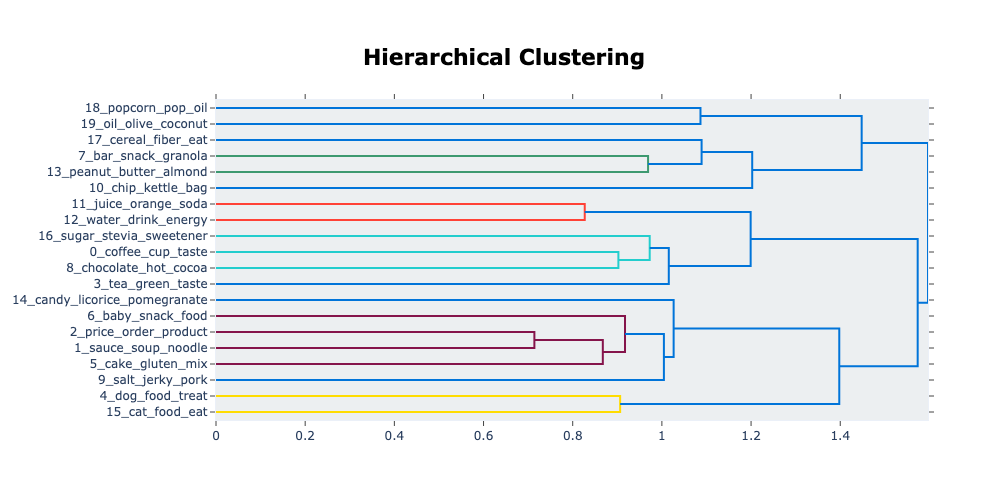

In [14]:
# Visualize connections between topics using hierachical clustering
topic_model.visualize_hierarchy(top_n_topics=20)

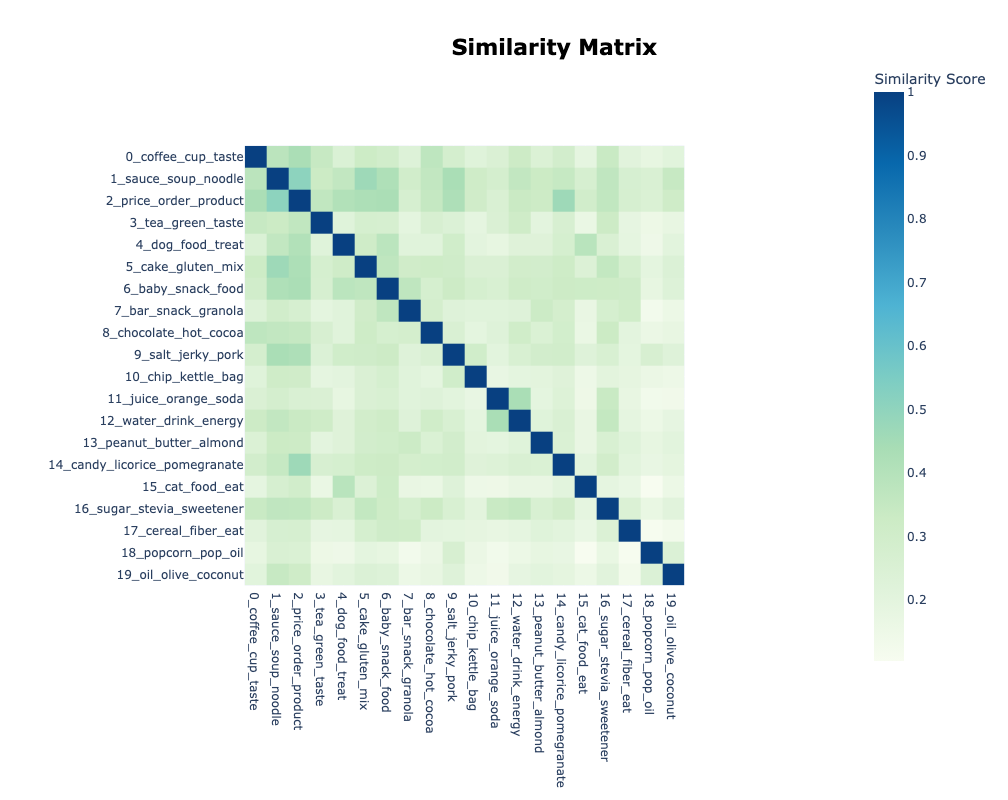

In [15]:
# Visualize similarity using heatmap
topic_model.visualize_heatmap()

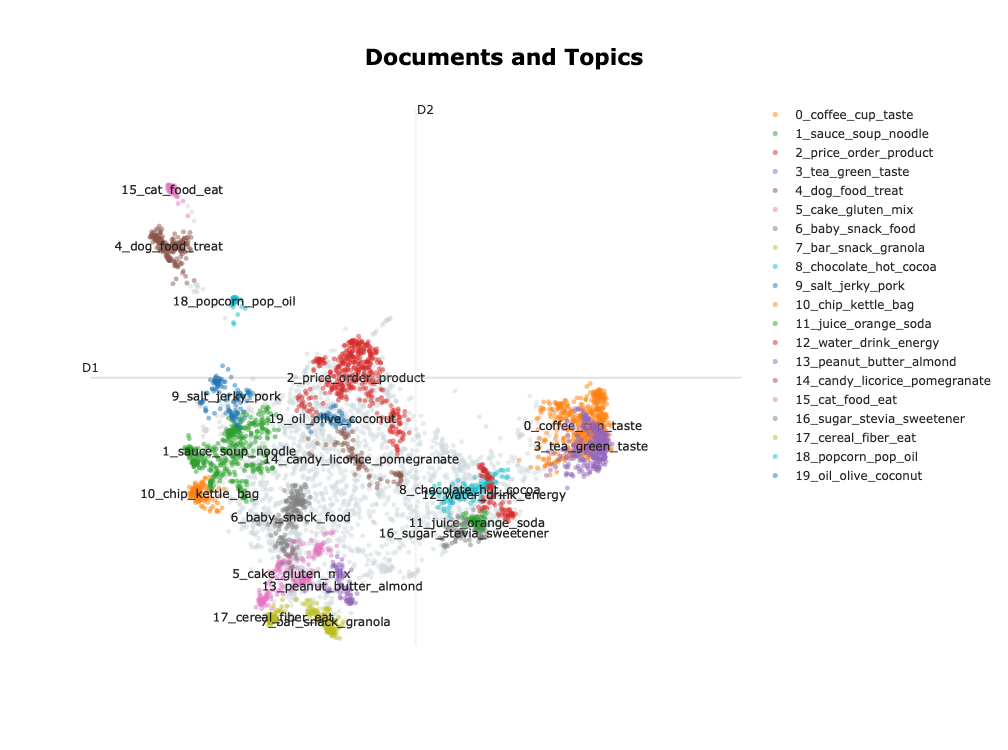

In [16]:
topic_model.visualize_documents(data["cleaned_text"], reduced_embeddings=umap_model.fit_transform(embeddings))

### Topics over time

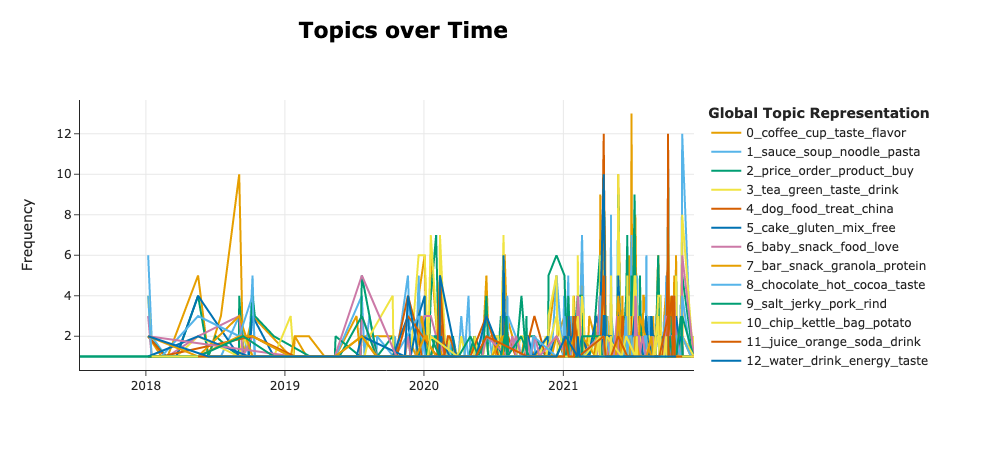

In [17]:
topics_over_time = topic_model.topics_over_time(data["cleaned_text"], data["time"])
topic_model.visualize_topics_over_time(topics_over_time)

### Topics by sentiment

In [18]:
sentiment = [i for i in data["label"]]

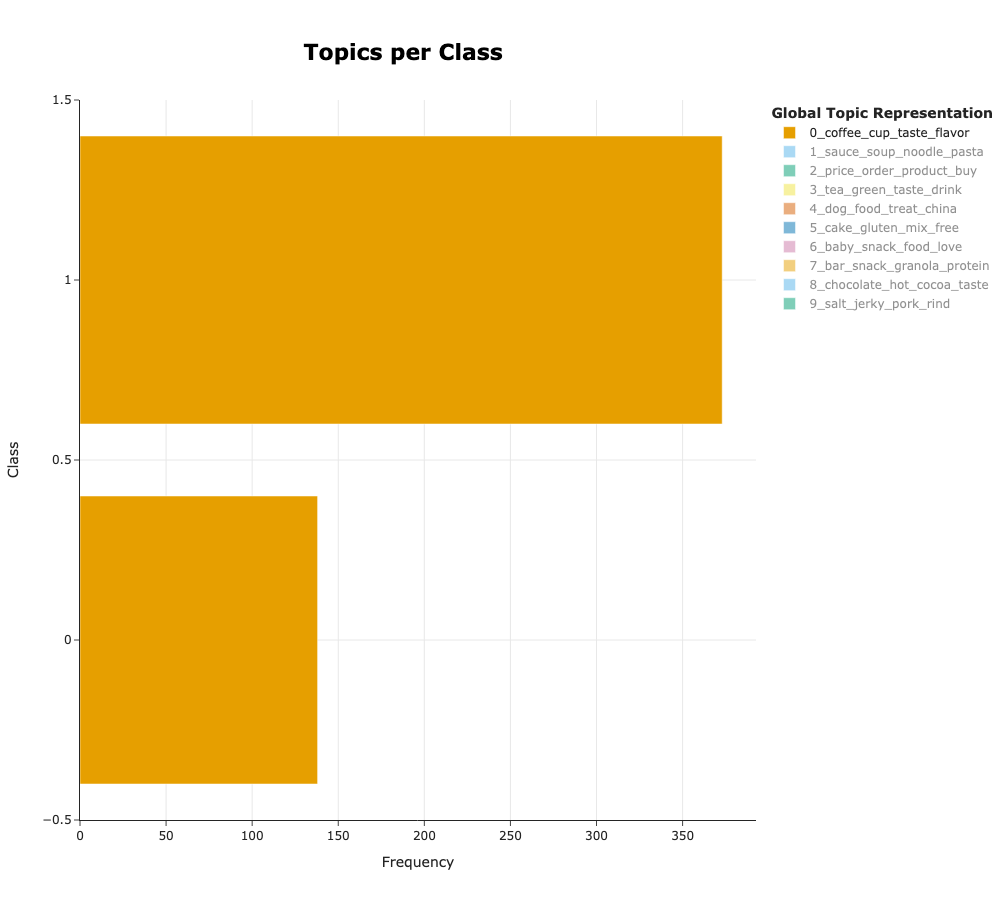

In [19]:
topics_by_sentiment = topic_model.topics_per_class(data["cleaned_text"], classes=sentiment)
topic_model.visualize_topics_per_class(topics_by_sentiment)

In [47]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(data["cleaned_text"], calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(data["cleaned_text"][5000], topic_token_distr[5000])
df

## Append topic to dataset

In [21]:
# Get the topic predictions
topic_prediction = topic_model.topics_[:]
# Save the predictions in the dataframe
data['topic_id'] = topic_prediction

In [23]:
topics_dict = topic_model.get_topics()
topics_df = pd.DataFrame()
for topic_id, topic in topics_dict.items():
    topic_df = pd.DataFrame(topic, columns=['word', 'weight'])
    topic_df['topic_id'] = topic_id
    topics_df = pd.concat([topics_df, topic_df], ignore_index=True)
topics_df

word    weight  topic_id
0      taste  0.023701        -1
1       good  0.020489        -1
2       like  0.020350        -1
3      great  0.019872        -1
4    product  0.019301        -1
..       ...       ...       ...
205     skin  0.036411        19
206  product  0.034087        19
207    great  0.033441        19
208    brand  0.025074        19
209    taste  0.024890        19

[210 rows x 3 columns]

In [24]:
data_df = data.merge(topics_df, on='topic_id')

In [115]:
pivoted_df = data_df.pivot_table(index=['sentiment', 'time','text', 'cleaned_text', 'label', 'topic_id'],
                                 columns=data_df.groupby(['sentiment', 'time','text', 'cleaned_text', 'label', 'topic_id']).cumcount() + 1,
                                 values=['word', 'weight'],
                                aggfunc = 'first').reset_index()
# Flatten the column names
pivoted_df.columns = ['_'.join(map(str, col)).strip() for col in pivoted_df.columns.values]

# # Rename the columns
pivoted_df = pivoted_df.rename(columns={'sentiment_': 'sentiment', 'time_': 'time', 'text_': 'text','cleaned_text_':'cleaned_text', 'label_': 'label', 'topic_id_': 'topic_id'})

column_order = ['sentiment', 'time', 'text', 'cleaned_text', 'label', 'topic_id']

for i in range(1, len(pivoted_df.columns[5:]), 2):
    column_order += [f'word_{i//2+1}', f'weight_{i//2+1}']

pivoted_df = pivoted_df.reindex(columns=column_order)

# Ensure same order as original df
data2 = data.set_index(["sentiment","time","text","cleaned_text","label"])
pivoted_df2 = pivoted_df.set_index(["sentiment","time","text","cleaned_text","label"])
output = pivoted_df2.reindex(data2.index).reset_index()
output.to_csv("../../data/processed/clean_reviews_w_topics.csv", index = False)